In [1]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import seaborn as sns

In [2]:
train_df = pd.read_csv('train.csv')
test_df = pd.read_csv('test.csv')
submission_samp = pd.read_csv('gender_submission.csv')
print(f'train_df = {train_df.shape}\ntest_df = {test_df.shape}')

train_df = (891, 12)
test_df = (418, 11)


In [3]:
train_df.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [4]:
train_df.columns

Index(['PassengerId', 'Survived', 'Pclass', 'Name', 'Sex', 'Age', 'SibSp',
       'Parch', 'Ticket', 'Fare', 'Cabin', 'Embarked'],
      dtype='object')

In [5]:
# Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
# Imputers
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer, SimpleImputer

from sklearn.preprocessing import OneHotEncoder, PowerTransformer

def data_cleaner(data):
    num_imputer = IterativeImputer(add_indicator=True)
#     cat_imputer = SimpleImputer(strategy = 'most_frequent')
    ohc = OneHotEncoder(sparse_output=False, drop='first', handle_unknown='ignore')
    yj_transformer = PowerTransformer()

    # Age
    try:
      data['Age'] = num_imputer.fit_transform(data['Age'].values.reshape(-1,1))
    except:
        pass
#     finally:
#         data['Age'] = data['Age'].apply(lambda x: 1 if x <= 15 else 2 if x <= 40 else 3 if x <= 60 else 4)

    # Fare
    try:
        data['Fare'] = num_imputer.fit_transform(data['Fare'].values.reshape(-1,1))
    except:
        pass
    finally:
        data['Fare'] = yj_transformer.fit_transform(data['Fare'].values.reshape(-1,1))

    # Embarked
#     data['Embarked'] = cat_imputer.fit_transform(data['Embarked'].values.reshape(-1,1))
    data['Embarked'].fillna('S',inplace = True)
    data['Family_Size'] = data['SibSp'] + data['Parch'] + 1 # 1 <--- Self
    data['Family_Size'] = data['Family_Size'].apply(lambda x: 1 if x == 1 else 2 if x<=4 else 3)
    data['Salutation'] = data['Name'].str.split(', ', expand=True)[1].str.split('.', expand=True)[0]
    data['Salutation'] = data['Salutation'].apply(lambda x: x if x in ('Mr', 'Miss', 'Mrs', 'Master') else 'Other')
    data['Family_Name'] = data['Name'].str.split(',',expand=True)[0]
    data['Family_Counts'] = data['Family_Name'].apply(lambda x: pd.Series.to_dict(data['Family_Name'].value_counts()).get(x))

    # Encoding
    encoded_cats = ohc.fit_transform(data[['Sex', 'Embarked', 'Salutation']])
    data = pd.concat([data, pd.DataFrame(encoded_cats, columns=ohc.get_feature_names_out())], axis=1, join='inner')

    # Dropping un necessary columns
    data.drop(['Name', 'Sex','SibSp', 'Parch', 'Ticket','Cabin', 'Embarked',
              'Salutation', 'Family_Name',], inplace = True,axis=1)
#     print(data.columns)
#     data = yj_transformer.fit_transform(data)
    return data

In [6]:
global flag
flag=1
try:
    train_df = data_cleaner(train_df)
    test_df = data_cleaner(test_df)
    flag = 1
except:
    print("Already Preprocessed" if flag==1 else "Something's Wrong")

train_df.head()

,PassengerId,Survived,Pclass,Age,Fare,Family_Size,Family_Counts,Sex_male,Embarked_Q,Embarked_S,Salutation_Miss,Salutation_Mr,Salutation_Mrs,Salutation_Other
0,1,0,3,22.0,-0.878820,2,2,1.0,0.0,1.0,0.0,1.0,0.0,0.0
1,2,1,1,38.0,1.336651,2,1,0.0,0.0,0.0,0.0,0.0,1.0,0.0
2,3,1,3,26.0,-0.790065,1,1,0.0,0.0,1.0,1.0,0.0,0.0,0.0
3,4,1,1,35.0,1.067352,2,2,0.0,0.0,1.0,0.0,0.0,1.0,0.0
4,5,0,3,35.0,-0.774439,1,2,1.0,0.0,1.0,0.0,1.0,0.0,0.0


In [7]:
X = train_df.drop('Survived', axis = 1)
y = train_df['Survived']

In [8]:
from sklearn.model_selection import train_test_split, GroupShuffleSplit

def group_splitter(X,y, train_size=0.75, random_state = 42):
    splitter = GroupShuffleSplit(n_splits = 2,
                                 train_size = train_size,
                                 random_state = random_state)
    train, test = next(splitter.split(X,y))
    return ((X.iloc[train], y.iloc[train]),(X.iloc[test], y.iloc[test]))

X_train, X_test, y_train, y_test = train_test_split(X, y, train_size = 0.7, stratify = y)
X_valid, X_test, y_valid, y_test = train_test_split(X_test, y_test, test_size = 0.5, stratify = y_test)

In [9]:
print(X_train.shape, X_valid.shape, X_test.shape)
print(y_train.shape, y_valid.shape, y_test.shape)

(623, 13) (134, 13) (134, 13)
(623,) (134,) (134,)


In [10]:
input_shape = X_train.shape[1]
print(input_shape)

13


In [11]:
from tensorflow import keras
from keras import layers
from keras.callbacks import EarlyStopping

early_stopper = EarlyStopping(min_delta = 0.001, patience=20,
                             restore_best_weights=True)

model = keras.Sequential([
    layers.Dense(units = 20, input_shape = (13,), activation = 'swish'),
    layers.BatchNormalization(),

    layers.Dense(units = 20,activation='relu',
                 kernel_initializer=keras.initializers.RandomNormal(), kernel_regularizer='l2', use_bias = False),
    layers.Dropout(0.1),
    layers.BatchNormalization(),

    layers.Dense(units = 60,activation='relu',
        kernel_initializer=keras.initializers.RandomNormal(), kernel_regularizer='l2', use_bias = False),
    layers.Dropout(0.33),
    layers.BatchNormalization(),

    layers.Dense(units = 20,activation='tanh',
                 kernel_initializer=keras.initializers.RandomNormal(),  kernel_regularizer='l2', use_bias = False),
    layers.Dropout(0.1),
    layers.Dense(units = 1, activation = 'sigmoid',)
])

model.compile(
    optimizer = keras.optimizers.RMSprop(learning_rate=0.003),
    loss='binary_crossentropy',
              metrics=[keras.metrics.BinaryAccuracy(),keras.metrics.Precision(),
                       keras.metrics.FalseNegatives(), keras.metrics.BinaryCrossentropy()]
)

In [12]:
history = model.fit(
    X_train,y_train,
    validation_data=(X_valid, y_valid),
    batch_size=16,
    epochs = 1000,
    verbose = 0,
    callbacks=[early_stopper]
)

Index(['loss', 'binary_accuracy', 'precision', 'false_negatives',
       'binary_crossentropy', 'val_loss', 'val_binary_accuracy',
       'val_precision', 'val_false_negatives', 'val_binary_crossentropy'],
      dtype='object')


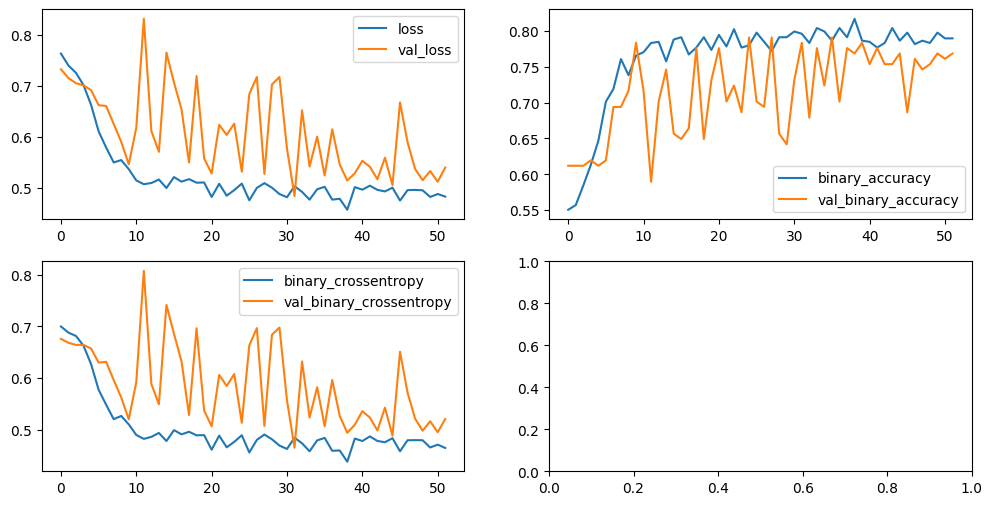

In [13]:
history_df = pd.DataFrame(history.history)
print(history_df.columns)
fig, axes = plt.subplots(2,2, figsize=(12,6))
try:
    history_df.loc[:,['loss','val_loss']].plot(ax = axes[0][0])
    history_df.loc[:,['binary_accuracy','val_binary_accuracy']].plot(ax = axes[0][1])
    history_df.loc[:,['binary_crossentropy','val_binary_crossentropy']].plot(ax = axes[1][0])
    history_df.loc[:,['false_positives','val_false_positives']].plot(ax = axes[1][1])
except:
    pass
for _ in range(1,10):
    try:
        history_df.loc[:,[f'binary_crossentropy_{_}',f'val_binary_crossentropy_{_}']].plot(ax = axes[1][0])
    except:
        pass
    try:
        history_df.loc[:,[f'false_negatives_{_}',f'val_false_negatives_{_}']].plot(ax = axes[1][1])
    except:
        pass

In [14]:
model.evaluate(X_test,y_test)

5/5 [==============================] - 0s 7ms/step - loss: 0.4321 - binary_accuracy: 0.8284 - precision: 0.8500 - false_negatives: 17.0000 - binary_crossentropy: 0.4136


[0.4321182370185852,
 0.8283582329750061,
 0.8500000238418579,
 17.0,
 0.41360482573509216]

5/5 [==============================] - 0s 6ms/step


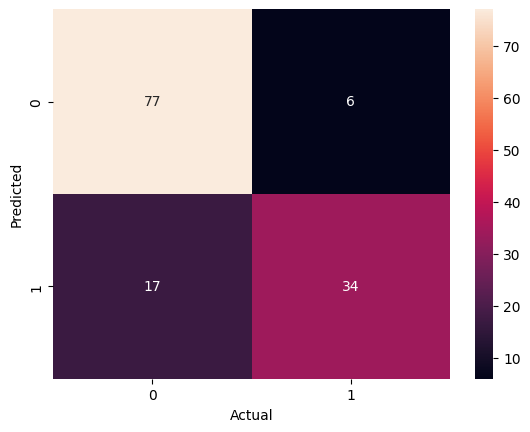

In [15]:
from tensorflow.math import confusion_matrix
y_preds = model.predict(X_test)
y_preds = (y_preds>0.5).astype('int').ravel()
cf = confusion_matrix(y_test,y_preds)
fig = sns.heatmap(cf, annot=True)
fig.set_xlabel("Actual")
fig.set_ylabel("Predicted")
plt.show()